In [1]:
import psycopg2 as pg2
import pandas as pd
conn = pg2.connect("dbname=postgres user=goeuro password=ecdKIeqx7692 host=35.197.223.45")

In [2]:
cur=conn.cursor()

## MAIN STEPS OF OUR PRODUCT FUNNEL: 

* Sessions: Visits to the website
* Searches: Searches made on GoEuro
* Clickout: Click journey event, user redirected to booking
* Bookings: Payment stage, leading to a booking confirmation


## OVERALL VALUES FOR VARIOUS STEPS IN OUR FUNNEL

### SESSIONS-STEP

In [3]:
df_sessions = pd.read_sql_query("SELECT * FROM sessions ", conn)

In [4]:
df_sessions.shape

(118158, 6)

In [5]:
pd.read_sql_query("SELECT COUNT (*) FROM (SELECT DISTINCT date_, device_type, domain_, user_country, channel FROM sessions) a", conn)

,count
0,118158


* This query is indicative of the fact that all rows in the 'Sessions' table represent a unique combination of date_,device_type, domain_, user_country & channel.


* There are a total of 118,158 combinations of date_,device_type, domain_, user_country & channel that have led to session events


* Now we can run an aggregate function (SUM) on the sessions column  to obtain the total number of sessions in our first step of product funnel

In [6]:
pd.read_sql_query("SELECT SUM(sessions) FROM sessions ", conn)

,sum
0,1.930793e+09


* **Key Finding:** "1,930,793,424" sessions were created --> This is the total value for the first step of our product funnel. 

### SEARCHES-STEP

In [7]:
df_searches = pd.read_sql_query("SELECT * FROM searches ", conn)

In [8]:
df_searches.shape

(109460, 6)

In [9]:
pd.read_sql_query("SELECT COUNT (*) FROM (SELECT DISTINCT date_, device_type, domain_, user_country, channel FROM searches) a", conn)

,count
0,109460


In [10]:
pd.read_sql_query("SELECT SUM(searches) FROM searches ", conn)

,sum
0,2.781660e+09


#### **KEY FINDINGS:**
 
* "2,781,660,497" searches were performed in total 


* The number of searches exceed the total number of sessions, this makes sense as there isnt a one-to-one relationship between the users and searches *(As a single user might perform multiple searches and some might not perform any)*


* To better explore this step of the funnel we will be looking at what combinations of date_, devicetype, domain, user_country & channel did result in searches and which ones didn't. 

In [11]:
pd.read_sql_query("SELECT COUNT (*) FROM (SELECT sessions.date_, sessions.device_type, sessions.domain_, sessions.user_country, sessions.channel FROM sessions INTERSECT  SELECT searches.date_, searches.device_type, searches.domain_, searches.user_country, searches.channel FROM searches) a", conn)

,count
0,107363


In [12]:
pd.read_sql_query("SELECT SUM(searches) FROM(SELECT searches.date_, searches.device_type, searches.domain_, searches.user_country, searches.channel, searches.searches FROM searches INNER JOIN sessions ON searches.date_ = sessions.date_  AND searches.device_type =sessions.device_type AND searches.domain_=sessions.domain_  AND searches.user_country=sessions.user_country  AND searches.channel=sessions.channel) a ", conn)

,sum
0,2.767929e+09


#### **KEY FINDINGS:**
* "107363" combinations of date_, devicetype, domain, user_country & channel that existed in the sessions table did result in searches as evident from the query above 
* (109460 - 107363) = "2097" combinations  were unique to this table.
* "2,767,929,006" searches were a result of followup from sessions 
* "13,731,491" searches were not followups from sessions

### CLICKOUT-STEP

In [13]:
df_clickouts = pd.read_sql_query("SELECT * FROM clickouts ", conn)

In [14]:
df_clickouts.shape

(176696, 7)

In [15]:
pd.read_sql_query("SELECT COUNT (*) FROM (SELECT DISTINCT date_, device_type, domain_, user_country, channel, provider_id FROM clickouts) a", conn)

,count
0,176696


In [16]:
pd.read_sql_query("SELECT SUM(clickouts) FROM clickouts ", conn)

,sum
0,607926000.0


In [17]:
pd.read_sql_query("SELECT COUNT (*) FROM (SELECT s.date_, s.device_type, s.domain_, s.user_country, s.channel, cl.provider_id FROM searches as s RIGHT JOIN clickouts as cl ON  s.date_ = cl.date_ AND s.device_type = cl.device_type AND s.domain_ = cl.domain_ AND s.user_country = cl.user_country AND s.channel=cl.channel WHERE s.date_ IS NOT null  AND s.device_type IS NOT null AND s.domain_ IS NOT null AND s.user_country IS NOT null AND s.channel IS NOT null AND cl.provider_id IS NOT null) a", conn)

,count
0,176681


In [18]:
pd.read_sql_query("SELECT SUM (clickouts) FROM (SELECT s.date_, s.device_type, s.domain_, s.user_country, s.channel, cl.provider_id, cl.clickouts FROM searches as s RIGHT JOIN clickouts as cl ON  s.date_ = cl.date_ AND s.device_type = cl.device_type AND s.domain_ = cl.domain_ AND s.user_country = cl.user_country AND s.channel=cl.channel WHERE s.date_ IS NOT null  AND s.device_type IS NOT null AND s.domain_ IS NOT null AND s.user_country IS NOT null AND s.channel IS NOT null AND cl.provider_id IS NOT null) a", conn)

,sum
0,607922000.0


#### KEY FINDINGS: 

* There were a total of "607,926,000" clickouts
* "607,922,000" clickouts were directly off of search results from the previous step in the funnel

### BOOKINGS-STEP

In [19]:
df_bookings= pd.read_sql_query("SELECT * FROM bookings ", conn)

In [20]:
df_bookings.shape

(92908, 7)

In [21]:
pd.read_sql_query("SELECT COUNT (*) FROM (SELECT DISTINCT date_, device_type, domain_, user_country, channel, provider_id FROM bookings) a", conn)

,count
0,92908


In [25]:
pd.read_sql_query("SELECT SUM(bookings) FROM bookings", conn)

,sum
0,133755360.0


In [23]:
pd.read_sql_query( "SELECT SUM (bookings) FROM (SELECT cl.date_, cl.device_type, cl.domain_, cl.user_country, cl.channel, cl.provider_id, bk.bookings FROM clickouts as cl RIGHT JOIN bookings as bk ON  cl.date_ = bk.date_ AND cl.device_type = bk.device_type AND cl.domain_ = bk.domain_ AND cl.user_country = bk.user_country AND cl.channel=bk.channel AND cl.provider_id = bk.provider_id  WHERE cl.date_ IS NOT null  AND cl.device_type IS NOT null AND cl.domain_ IS NOT null AND cl.user_country IS NOT null AND cl.channel IS NOT null AND bk.provider_id IS NOT null) a", conn)

,sum
0,133655355.0


### OVERALL CONVERSION RATIO

* **(133755360/1,930,793,424)*100 = ~ "6.927%"**
* **133755360 - 133655355 = "100005" bookings were not followup from clickouts**

### SUMMARY OF PRODUCT FUNNEL 

* "1,930,793,424" Total Sessions
* "2,767,929,006" Total Searches 
* "607,926,000"  Total Clickouts, "607,922,000" clickouts were directly off of search results from previous step
* "133755360" Total Bookings, responsible for a ~6.927% overall conversion ratio ((133755360/1,930,793,424) *100 = ~6.927% )
* "100005" bookings were not followup from clickouts


## DATA EXPLORATION

### Sessions Exploration

In [27]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118158 entries, 0 to 118157
Data columns (total 6 columns):
date_           118158 non-null datetime64[ns]
device_type     118158 non-null object
domain_         118158 non-null object
user_country    118158 non-null object
channel         118158 non-null object
sessions        118158 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 5.4+ MB


In [29]:
df_sessions.head()

,date_,device_type,domain_,user_country,channel,sessions
0,2016-11-18,Mobile,goeuro-com,Italy,Direct,38850
1,2016-11-20,Computer,goeuro-it,Italy,Referral,8190
2,2016-11-18,Mobile,goeuro-es,United Kingdom,Remarketing,1470
3,2016-11-14,Computer,goeuro-co-uk,Germany,Organic Search,2352
4,2016-11-17,Computer,goeuro-it,Germany,Direct,546


In [31]:
df_sessions.iloc[0]['date_'] #First logged session-event

Timestamp('2016-11-18 00:00:00')

In [33]:
df_sessions.iloc[-1]['date_'] #Last logged sesion-event

Timestamp('2017-06-11 00:00:00')

In [111]:
df_sessions.iloc[-1]['date_'] - df_sessions.iloc[0]['date_'] #Total span of our events recorded

Timedelta('205 days 00:00:00')

In [112]:
df_sessions.groupby(df_sessions['date_'].dt.month).sum()['sessions'] #Total sessions per month
 

date_
1     252019614
2     263906202
3     300058416
4     283921428
5     291523890
6     132997242
11    150355506
12    256011126
Name: sessions, dtype: int64

In [123]:
df_sessions.groupby(df_sessions['date_'].dt.month).sum()['sessions'].describe() #Descriptive statistics about monthly sessions

count    8.000000e+00
mean     2.413492e+08
std      6.395793e+07
min      1.329972e+08
25%      2.266036e+08
50%      2.599587e+08
75%      2.858220e+08
max      3.000584e+08
Name: sessions, dtype: float64

#### KEY FINDINGS
* The month of November 2016, and June 2017 have significantly low sessions but it can be explained by the fact that we only have the data for the last 13 days of November, and first 11 days of the month of June

In [113]:
df_sessions.groupby(df_sessions['date_'].dt.day).sum()['sessions'] #Total Sessions per day


date_
1     63928998
2     67006716
3     64164618
4     64837878
5     67982628
6     65956002
7     65061276
8     64482894
9     64320270
10    63055776
11    64221906
12    69037584
13    66276000
14    61215840
15    61945632
16    61040406
17    61433106
18    60633258
19    62944560
20    64673952
21    64256430
22    64367478
23    62977278
24    59841894
25    59343396
26    63227766
27    65229822
28    63768516
29    55190436
30    54838434
31    33532674
Name: sessions, dtype: int64

* The 31st day has the least overall sessions, which is consistent with the fact that not all the months  have 31 days.

In [124]:
df_sessions.groupby(df_sessions['date_'].dt.day).sum()['sessions'].describe() #Descriptive statistics about daily sessions data

count    3.100000e+01
mean     6.228366e+07
std      6.173892e+06
min      3.353267e+07
25%      6.132447e+07
50%      6.392900e+07
75%      6.475592e+07
max      6.903758e+07
Name: sessions, dtype: float64

In [159]:
pie_dist=df_sessions.groupby(df_sessions['channel']).sum()['sessions'] #Breakdown of sessions per channel
pie_dist

channel
Affiliate           5943378
Direct            114361254
Email                671664
Organic Search    612778446
Other               3747366
Paid Search       986775552
Referral           87248280
Remarketing       110908644
Social Organic      5408508
Social Paid         2950332
Name: sessions, dtype: int64

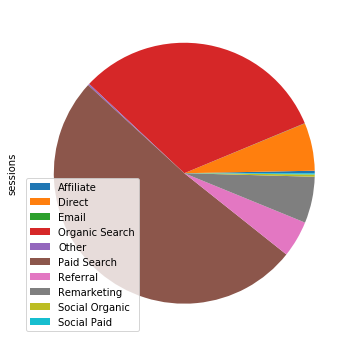

In [203]:
import matplotlib.pyplot as plt
pie_dist.plot.pie(fontsize=10, figsize=(9, 6), legend=True, labels=None)

In [169]:
pie_dist_1=df_sessions.groupby(df_sessions['device_type']).sum()['sessions'] #Breakdown of sessions per device type
pie_dist_1

device_type
Computer     693193746
Mobile      1099670250
Tablet       137929428
Name: sessions, dtype: int64

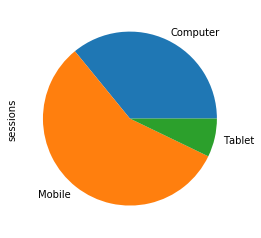

In [170]:
pie_dist_1.plot.pie()

In [171]:
pie_dist_2=df_sessions.groupby(df_sessions['domain_']).sum()['sessions'] #Breakdown of sessions per domain
pie_dist_2

domain_
goeuro-co-uk    311504928
goeuro-com      240069606
goeuro-de       287992866
goeuro-es       447307728
goeuro-fr       216578250
goeuro-it       427340046
Name: sessions, dtype: int64

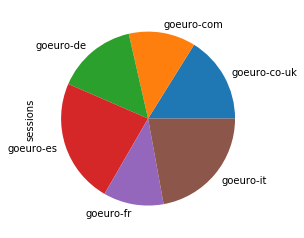

In [172]:
pie_dist_2.plot.pie()

In [173]:
pie_dist_3=df_sessions.groupby(df_sessions['user_country']).sum()['sessions'] #Breakdown of sessions per country
pie_dist_3

user_country
France            254661372
Germany           372868776
Italy             474079704
Spain             474779130
United Kingdom    354404442
Name: sessions, dtype: int64

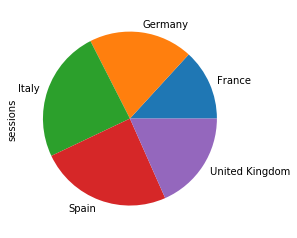

In [174]:
pie_dist_3.plot.pie()

In [118]:
import seaborn as sns
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt 

### SEARCHES-EXPLORATION

In [125]:
df_searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109460 entries, 0 to 109459
Data columns (total 6 columns):
date_           109460 non-null datetime64[ns]
device_type     109460 non-null object
domain_         109460 non-null object
user_country    109460 non-null object
channel         109460 non-null object
searches        109460 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 5.0+ MB


In [126]:
df_searches.head()

,date_,device_type,domain_,user_country,channel,searches
0,2017-01-06,Mobile,goeuro-it,Italy,Paid Search,679486
1,2017-01-09,Mobile,goeuro-es,France,Paid Search,21027
2,2017-01-12,Mobile,goeuro-com,Italy,Organic Search,24639
3,2017-01-17,Mobile,goeuro-it,Italy,Paid Search,701975
4,2017-01-11,Computer,goeuro-fr,France,Direct,12728


In [128]:
df_searches.iloc[0]['date_'] #First logged search-event

Timestamp('2017-01-06 00:00:00')

In [129]:
df_searches.iloc[-1]['date_'] #Last logged search-event

Timestamp('2017-04-06 00:00:00')

In [131]:
df_searches.groupby(df_searches['date_'].dt.month).sum()['searches'] #Total searches per month


date_
1     330138434
2     349252364
3     443962014
4     456355173
5     455348973
6     206989960
11    189154635
12    350458944
Name: searches, dtype: int64

In [132]:
df_searches.groupby(df_searches['date_'].dt.month).sum()['searches'].describe() #Descriptive statistics about monthly searches

count    8.000000e+00
mean     3.477076e+08
std      1.055022e+08
min      1.891546e+08
25%      2.993513e+08
50%      3.498557e+08
75%      4.468088e+08
max      4.563552e+08
Name: searches, dtype: float64

In [134]:
df_searches.groupby(df_searches['date_'].dt.day).sum()['searches'] #Total searches per day


date_
1      92396422
2      97145643
3      92288578
4      93647464
5      99955865
6      98165603
7      94927058
8      93910366
9      97828655
10     94788770
11     96667913
12    100983522
13     94884359
14     86212162
15     88173005
16     87344696
17     85890780
18     84676073
19     86549927
20     88430188
21     88679416
22     92553673
23     90406210
24     87070872
25     84882258
26     90070251
27     92948542
28     92953057
29     79477760
30     79358048
31     48393361
Name: searches, dtype: int64

In [135]:
df_searches.groupby(df_searches['date_'].dt.day).sum()['searches'].describe() #Descriptive statistics about daily searches

count    3.100000e+01
mean     8.973098e+07
std      9.401552e+06
min      4.839336e+07
25%      8.681040e+07
50%      9.228858e+07
75%      9.483656e+07
max      1.009835e+08
Name: searches, dtype: float64

In [175]:
pie_dist_4=df_searches.groupby(df_searches['channel']).sum()['searches'] #Breakdown of searches per channel
pie_dist_4

channel
Affiliate            6417492
Direct             170295265
Email                1283593
Organic Search     866114686
Other                1324572
Paid Search       1449689315
Referral           140764886
Remarketing        127284386
Social Organic       4361533
Social Paid           417229
direct               1976151
internal              926908
organic              5599245
other                   2021
referrer               17802
sem                  5162924
social                 22489
Name: searches, dtype: int64

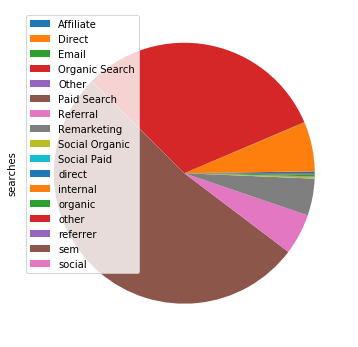

In [202]:
fig=pie_dist_4.plot.pie( fontsize=10, figsize=(9, 6), legend=True, labels=None)


In [207]:
pie_dist_5=df_searches.groupby(df_searches['device_type']).sum()['searches'] #Breakdown of searches per device type
pie_dist_5

device_type
Computer    1278157714
Mobile      1345547830
Tablet       157954953
Name: searches, dtype: int64

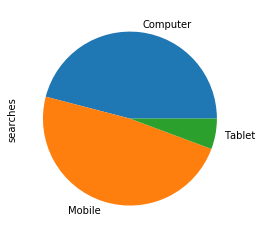

In [208]:
fig=pie_dist_5.plot.pie()


In [209]:
pie_dist_6=df_searches.groupby(df_searches['domain_']).sum()['searches'] #Breakdown of searches per domain
pie_dist_6

domain_
goeuro-co-uk    433322911
goeuro-com      453496404
goeuro-de       402310021
goeuro-es       648170949
goeuro-fr       300972824
goeuro-it       543387388
Name: searches, dtype: int64

pie_dist_6.plot.pie()

In [211]:
pie_dist_7=df_searches.groupby(df_searches['user_country']).sum()['searches'] #Breakdown of searches per country
pie_dist_7

user_country
France            389647037
Germany           572116290
Italy             635238011
Spain             688934089
United Kingdom    495725070
Name: searches, dtype: int64

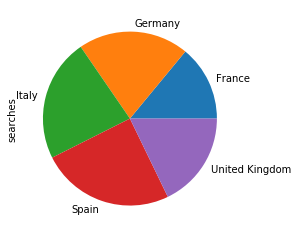

In [212]:
pie_dist_7.plot.pie()

### PROVIDERS-EXPLORATION

In [213]:
df_providers = pd.read_sql_query("SELECT * FROM providers ", conn)

In [214]:
df_providers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
provider_id    16 non-null int64
travel_mode    16 non-null object
dtypes: int64(1), object(1)
memory usage: 336.0+ bytes


In [242]:
df_providers

,provider_id,travel_mode
0,15,air
1,11,train
2,5,train
3,7,air
4,8,air
5,4,air
6,6,train
7,12,bus
8,3,train
9,14,train


In [218]:
pie_dist_8=df_providers.groupby(df_providers['travel_mode']).count() #Breakdown of providers per travel mode
pie_dist_8

,provider_id
travel_mode,
air,4
bus,2
train,10


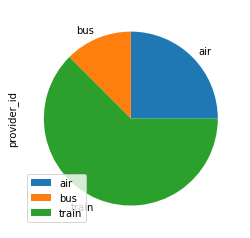

In [221]:
pie_dist_8.plot.pie(y='provider_id')

* Most of the Providers are Train providers followed by Air and Bus respectively

### Bookings

In [224]:
df_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92908 entries, 0 to 92907
Data columns (total 7 columns):
date_           92908 non-null datetime64[ns]
device_type     92908 non-null object
domain_         92908 non-null object
user_country    92908 non-null object
channel         92908 non-null object
provider_id     92908 non-null int64
bookings        92908 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 5.0+ MB


In [225]:
df_bookings.head()

,date_,device_type,domain_,user_country,channel,provider_id,bookings
0,2016-11-14,Computer,goeuro-com,France,Direct,2,885.0
1,2016-11-14,Computer,goeuro-com,France,Direct,3,885.0
2,2016-11-14,Computer,goeuro-com,France,Direct,10,295.0
3,2016-11-14,Computer,goeuro-com,France,Organic Search,2,2360.0
4,2016-11-14,Computer,goeuro-com,France,Organic Search,3,590.0


In [261]:
df_bookings.groupby(df_bookings['date_'].dt.month).sum()['bookings'] #Total bookings per month

date_
1     12811555.0
2     16896420.0
3     22584315.0
4     22619125.0
5     25144030.0
6     13231635.0
11     7467630.0
12    13000650.0
Name: bookings, dtype: float64

In [262]:
df_bookings.groupby(df_bookings['date_'].dt.month).sum()['bookings'].describe() #Descriptive stats about bookings per month

count    8.000000e+00
mean     1.671942e+07
std      6.176798e+06
min      7.467630e+06
25%      1.295338e+07
50%      1.506403e+07
75%      2.259302e+07
max      2.514403e+07
Name: bookings, dtype: float64

In [264]:
df_bookings.groupby(df_bookings['date_'].dt.day).sum()['bookings'] #Total bookings per day

date_
1     4456270.0
2     4741830.0
3     4635335.0
4     4698760.0
5     5109105.0
6     4961015.0
7     4954820.0
8     4789620.0
9     4834460.0
10    4606130.0
11    4460695.0
12    4831510.0
13    4873400.0
14    4038255.0
15    4091060.0
16    4203455.0
17    3970405.0
18    3869515.0
19    3922025.0
20    4098140.0
21    4110235.0
22    4206995.0
23    4258620.0
24    4098730.0
25    3822610.0
26    4188410.0
27    4281630.0
28    4331780.0
29    3872760.0
30    3851225.0
31    2586560.0
Name: bookings, dtype: float64

In [230]:
df_bookings.groupby(df_searches['date_'].dt.day).sum()['bookings'].describe() #Descriptive stats about bookings per day

count    3.100000e+01
mean     4.314689e+06
std      4.691827e+05
min      2.414870e+06
25%      4.195342e+06
50%      4.378685e+06
75%      4.537985e+06
max      5.022670e+06
Name: bookings, dtype: float64

In [231]:
pie_dist_9=df_bookings.groupby(df_bookings['channel']).sum()['bookings'] #Breakdown of bookings per channel
pie_dist_9

channel
Affiliate           362260.0
Direct            12623050.0
Email               369930.0
Organic Search    37025745.0
Other                33040.0
Paid Search       72404800.0
Referral           7858505.0
Remarketing        2684205.0
Social Organic      385565.0
Social Paid           8260.0
direct                   0.0
internal                 0.0
organic                  0.0
sem                      0.0
Name: bookings, dtype: float64

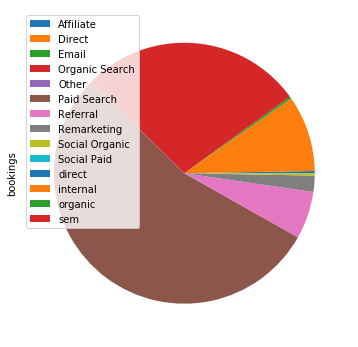

In [234]:
pie_dist_9.plot.pie(fontsize=10, figsize=(9, 6), legend=True, labels=None)

In [251]:
pie_dist_11=df_bookings.groupby(df_bookings['domain_']).sum()['bookings'] #Breakdown of bookings per domain
pie_dist_11

domain_
goeuro-co-uk    18826015.0
goeuro-com      38534670.0
goeuro-de       17378450.0
goeuro-es       33319955.0
goeuro-fr       10776940.0
goeuro-it       14919330.0
Name: bookings, dtype: float64

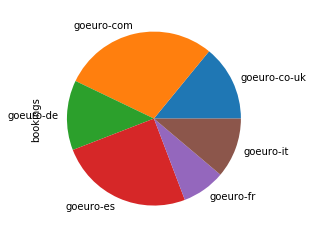

In [253]:
pie_dist_11.plot.pie()

In [255]:
pie_dist_12=df_bookings.groupby(df_bookings['device_type']).sum()['bookings'] #Breakdown of bookings per device
pie_dist_12

device_type
Computer    80034385.0
Mobile      46807650.0
Tablet       6913325.0
Name: bookings, dtype: float64

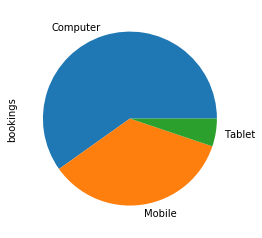

In [256]:
pie_dist_12.plot.pie()

In [273]:
pie_dist_13=df_bookings.groupby(df_bookings['user_country']).sum()['bookings'] #Breakdown of bookings per country
pie_dist_13

user_country
France            15000160.0
Germany           27212865.0
Italy             26035520.0
Spain             43835230.0
United Kingdom    21671585.0
Name: bookings, dtype: float64

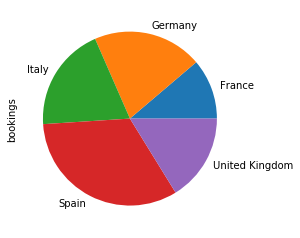

In [258]:
pie_dist_13.plot.pie()

### KEY FINDINGS ABOUT DIFFERENT PROVIDERS-BOOKINGS

In [236]:
pie_dist_10=df_bookings.groupby(df_bookings['provider_id']).sum()['bookings'] #Breakdown of bookings per provider
pie_dist_10

provider_id
1     19088270.0
2     28584320.0
3      8757665.0
4      4370720.0
5     10444180.0
9         1475.0
10    20018700.0
11      233640.0
12      406215.0
13    12569360.0
14    26383030.0
16     2897785.0
Name: bookings, dtype: float64

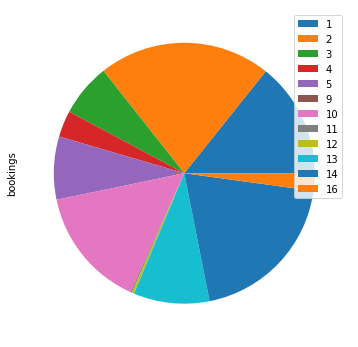

In [237]:
pie_dist_10.plot.pie(fontsize=10, figsize=(9, 6), legend=True, labels=None)

In [244]:
travel_air= pie_dist_10[4]
travel_air

4370720.0

In [245]:
travel_bus= pie_dist_10[12]+ pie_dist_10[1]

In [246]:
travel_bus

19494485.0

In [248]:
travel_train

109890155.0

In [247]:
travel_train= pie_dist_10[2]+pie_dist_10[10]+pie_dist_10[16]+pie_dist_10[9]+pie_dist_10[13]+pie_dist_10[11]+pie_dist_10[5]+pie_dist_10[3]+pie_dist_10[14] 

#### KEY FINDINGS
* Train leads the way in number of bookings with 109890155.0
* Buses is second with 19494485.0
* Air is the third with 4370720.0
* Providers 6,7,8,15 have no net bookings 

### MAJOR EVENTS

In [272]:
df_bookings.groupby(df_bookings['date_'].dt.date).sum()['bookings'].sort_values(ascending=True)

date_
2017-06-14       1180.0
2017-01-28     276415.0
2016-12-31     280545.0
2016-12-24     309455.0
2017-01-21     334530.0
2017-01-14     338660.0
2016-11-19     341020.0
2016-12-10     341315.0
2017-01-27     348395.0
2016-11-26     356655.0
2017-01-07     359605.0
2017-01-13     361965.0
2016-12-17     372290.0
2016-11-20     381140.0
2017-01-20     382320.0
2017-01-08     383500.0
2016-12-25     386155.0
2016-12-09     387630.0
2016-12-23     387925.0
2016-12-03     388220.0
2016-12-11     388810.0
2017-01-12     392055.0
2017-01-29     394120.0
2017-01-15     394415.0
2016-12-16     394710.0
2017-01-06     395005.0
2016-11-14     395890.0
2017-01-09     397365.0
2017-01-17     401200.0
2016-12-22     401495.0
                ...    
2017-06-10     841930.0
2017-05-28     844290.0
2017-03-28     853435.0
2017-03-09     853435.0
2017-05-24     856680.0
2017-03-29     866120.0
2017-06-03     869660.0
2017-04-10     873790.0
2017-03-13     879690.0
2017-04-06     894735.0
2017-04-04

##### KEY FINDING 
* THE lowest amount of bookins were on our last day of recorded bookings, because most likely we don't have round the day data for that day
* New Year's eve and Christmas eve were 2 out of our 4 least busiest days which is in line with intuition. 
* The most amount of bookings were mostly in the month of June 2017 which is indicative of high growth as the product gains more ground as time progresses